# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [96]:
!pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
  Using cached streamlit-1.40.1-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached protobuf-5.28.3-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7

In [65]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-11-22'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

[*********************100%***********************]  502 of 502 completed


In [66]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-25 A        42.194286   44.889999   45.009998   44.619999   44.740002   
           AAPL     25.882496   27.947500   27.967501   27.737499   27.782499   
           ABBV     42.917679   60.509998   60.669998   59.669998   60.040001   
           ABT      33.883244   39.160000   39.209999   38.939999   39.080002   
           ACGL     26.035601   27.379999   27.389999   27.160000   27.256666   
...                       ...         ...         ...         ...         ...   
2024-11-21 XYL     125.360001  125.360001  126.970001  122.900002  122.900002   
           YUM     134.220001  134.220001  134.429993  131.779999  133.160004   
           ZBH     108.400002  108.400002  109.589996  108.279999  109.419998   
           ZBRA    392.309998  392.309998  395.140015  382.779999  386.859985   
           ZTS     176.710007  176.710007  177.660004  174.550003  175.699997   

Price                  volume  
date       ticker              
2016-11-25 A         877100.0  
           AAPL    45903600.0  
           ABBV     2941600.0  
           ABT      2733000.0  
           ACGL      417900.0  
...                       ...  
2024-11-21 XYL      1686200.0  
           YUM      1031100.0  
           ZBH      1508200.0  
           ZBRA      368400.0  
           ZTS      2019500.0  

[987228 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [67]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - ((2*np.log(2) - 1)*(np.log(df['adj close']) - np.log(df['open']))**2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
        atr = pandas_ta.atr(high=stock_data['high'],
                            low=stock_data['low'],
                            close=stock_data['close'],
                            length=14)
        return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1,group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close= close,length =20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd']=df.groupby(level =1, group_keys=False)['adj close'].apply(compute_macd)
df['dollar volume'] = (df['adj close'] * df['volume'])/1e6

In [68]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-25 A        42.194286   44.889999   45.009998   44.619999   44.740002   
           AAPL     25.882496   27.947500   27.967501   27.737499   27.782499   
           ABBV     42.917679   60.509998   60.669998   59.669998   60.040001   
           ABT      33.883244   39.160000   39.209999   38.939999   39.080002   
           ACGL     26.035601   27.379999   27.389999   27.160000   27.256666   
...                       ...         ...         ...         ...         ...   
2024-11-21 XYL     125.360001  125.360001  126.970001  122.900002  122.900002   
           YUM     134.220001  134.220001  134.429993  131.779999  133.160004   
           ZBH     108.400002  108.400002  109.589996  108.279999  109.419998   
           ZBRA    392.309998  392.309998  395.140015  382.779999  386.859985   
           ZTS     176.710007  176.710007  177.660004  174.550003  175.699997   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-11-25 A         877100.0         -0.001288        NaN       NaN   
           AAPL    45903600.0         -0.001904        NaN       NaN   
           ABBV     2941600.0         -0.043402        NaN       NaN   
           ABT      2733000.0         -0.007841        NaN       NaN   
           ACGL      417900.0         -0.000776        NaN       NaN   
...                       ...               ...        ...       ...   
2024-11-21 XYL      1686200.0          0.000379  45.331505  4.778643   
           YUM      1031100.0          0.000174  49.765274  4.882601   
           ZBH      1508200.0          0.000038  50.895829  4.647004   
           ZBRA      368400.0          0.000429  58.556333  5.900907   
           ZTS      2019500.0          0.000143  44.269139  5.147066   

Price                bb_mid   bb_high       atr      macd  dollar volume  
date       ticker                                                         
2016-11-25 A            NaN       NaN       NaN       NaN      37.008609  
           AAPL         NaN       NaN       NaN       NaN    1188.099738  
           ABBV         NaN       NaN       NaN       NaN     126.246644  
           ABT          NaN       NaN       NaN       NaN      92.602905  
           ACGL         NaN       NaN       NaN       NaN      10.880278  
...                     ...       ...       ...       ...            ...  
2024-11-21 XYL     4.830709  4.882774  0.639987 -1.418258     211.382033  
           YUM     4.907032  4.931463  0.787700 -0.295066     138.394243  
           ZBH     4.695902  4.744799 -0.576203  0.480194     163.488882  
           ZBRA    5.960086  6.019265  0.142451  0.491767     144.527003  
           ZTS     5.181345  5.215623  0.778504 -1.317301     356.865859  

[987228 rows x 14 columns]

<Axes: xlabel='date'>

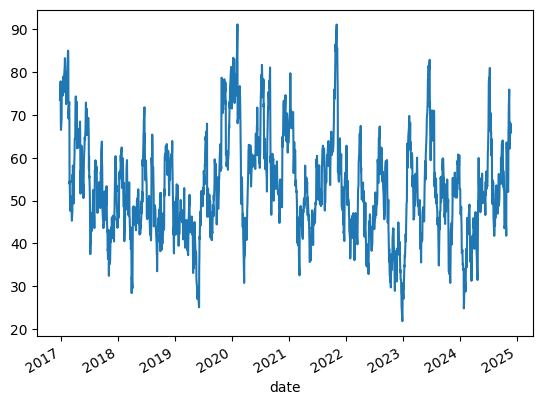

In [69]:
df.xs('TSLA', level = 1)['rsi'].plot()

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [70]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar volume', 'volume', 'open', 'high', 'low', 'close']]
data = (pd.concat([df.unstack('ticker')['dollar volume'].resample('M').mean().stack('ticker').to_frame('dollar volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1)).dropna()


In [71]:
data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A          102.349485   46.162552         -0.000339  60.788654   
           AAPL      3120.691182   28.095900         -0.002159  71.338092   
           ABBV       344.889469   43.780563         -0.038072  49.357318   
           ABT        371.924547   36.375004         -0.004523  71.618536   
           ACGL        29.688113   28.003962         -0.001044  61.242845   
...                          ...         ...               ...        ...   
2024-11-30 XYL        205.619296  125.360001          0.000379  45.331505   
           YUM        279.271939  134.220001          0.000174  49.765274   
           ZBH        177.258367  108.400002          0.000038  50.895829   
           ZBRA       153.779036  392.309998          0.000429  58.556333   
           ZTS        541.731375  176.710007          0.000143  44.269139   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.803595  3.833158  3.862721 -1.379476  0.131358  
           AAPL    3.327728  3.356231  3.384733 -1.445131 -0.131688  
           ABBV    3.779777  3.810983  3.842188 -1.437296 -0.330850  
           ABT     3.557928  3.591215  3.624503 -1.410997  0.180350  
           ACGL    3.331300  3.355690  3.380080 -1.172960 -0.001059  
...                     ...       ...       ...       ...       ...  
2024-11-30 XYL     4.778643  4.830709  4.882774  0.639987 -1.418258  
           YUM     4.882601  4.907032  4.931463  0.787700 -0.295066  
           ZBH     4.647004  4.695902  4.744799 -0.576203  0.480194  
           ZBRA    5.900907  5.960086  6.019265  0.142451  0.491767  
           ZTS     5.147066  5.181345  5.215623  0.778504 -1.317301  

[46635 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [72]:
data['dollar volume'] = data.loc[:, 'dollar volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()
data['dollar volume rank'] = data.groupby('date')['dollar volume'].rank(ascending=False)

In [73]:
data = data[data['dollar volume rank'] <150].drop(['dollar volume', 'dollar volume rank'], axis = 1)

In [74]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-12-31 AAPL     39.811527         -0.001775  47.784524  3.698682   
           ABBV     71.096046         -0.039988  55.000988  4.253741   
           ABT      50.525517         -0.006559  59.877739  3.884984   
           ACN     137.983627         -0.004850  65.003550  4.891671   
           ADBE    175.240005          0.000056  51.008415  5.137116   
...                       ...               ...        ...       ...   
2024-11-30 VZ       42.500000          0.000136  53.773760  3.717003   
           WFC      74.830002          0.000337  72.841793  4.130134   
           WMT      88.389999          0.000146  70.936192  4.400027   
           XOM     121.930000          0.000157  57.838479  4.752269   
           ZTS     176.710007          0.000143  44.269139  5.147066   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-12-31 AAPL    3.724109  3.749536 -1.255971 -0.269553  
           ABBV    4.278529  4.303317 -0.923657  0.075591  
           ABT     3.922018  3.959053 -1.371388  0.164980  
           ACN     4.921786  4.951901 -1.160813  0.224492  
           ADBE    5.167383  5.197650 -1.352164 -0.178949  
...                     ...       ...       ...       ...  
2024-11-30 VZ      3.745899  3.774795 -0.403877 -0.316069  
           WFC     4.252176  4.374217  1.865312  3.656667  
           WMT     4.442664  4.485301  2.444059  2.275034  
           XOM     4.785139  4.818009  0.481949  0.352210  
           ZTS     5.181345  5.215623  0.778504 -1.317301  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [75]:
a = df.xs('ZTS', level =1)
a

Price,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar volume
date,,,,,,,,,,,,,,
2016-11-25,47.402813,50.180000,50.490002,50.060001,50.349998,804700.0,-0.001369,NaN,NaN,NaN,NaN,NaN,NaN,38.145044
2016-11-28,47.374477,50.150002,50.389999,49.790001,50.000000,2695200.0,-0.001052,NaN,NaN,NaN,NaN,NaN,NaN,127.683691
2016-11-29,47.657875,50.450001,50.580002,50.029999,50.029999,2313600.0,-0.000852,NaN,NaN,NaN,NaN,NaN,NaN,110.261260
2016-11-30,47.591747,50.380001,50.820000,50.270000,50.610001,3782100.0,-0.001401,NaN,NaN,NaN,NaN,NaN,NaN,179.996747
2016-12-01,46.439266,49.160000,50.549999,48.619999,50.410000,4252000.0,-0.001843,NaN,NaN,NaN,NaN,NaN,NaN,197.459760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15,175.139999,175.139999,177.070007,170.750000,173.000000,3426500.0,0.000602,41.754751,5.136333,5.193184,5.250035,0.971872,-1.646718,600.117208
2024-11-18,176.419998,176.419998,177.199997,173.660004,174.130005,3172900.0,0.000138,43.476538,5.138298,5.189758,5.241218,0.926689,-1.549717,559.763012
2024-11-19,175.559998,175.559998,176.500000,173.240005,174.880005,2208300.0,0.000168,42.586203,5.141551,5.186074,5.230596,0.871007,-1.486462,387.689143


In [76]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.665623         -0.000835  37.072884  3.585046   
           ABBV     70.416016         -0.026539  57.957290  4.152361   
           ABT      65.209167         -0.003189  55.190185  4.111693   
           ACN     129.389038         -0.002485  36.633806  4.807611   
           ADBE    226.240005          0.000161  46.330419  5.329066   
...                       ...               ...        ...       ...   
2024-11-30 VRTX    450.369995          0.000240  40.886536  6.097885   
           VZ       42.500000          0.000136  53.773760  3.717003   
           WFC      74.830002          0.000337  72.841793  4.130134   
           WMT      88.389999          0.000146  70.936192  4.400027   
           XOM     121.930000          0.000157  57.838479  4.752269   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-12-31 AAPL    3.697134  3.809222 -0.670857 -1.246603  -0.116698   
           ABBV    4.223280  4.294199  0.751263 -0.105590  -0.022064   
           ABT     4.169437  4.227180  0.308984 -0.321888  -0.023227   
           ACN     4.940240  5.072869 -0.150528 -1.466634  -0.142900   
           ADBE    5.452557  5.576047 -0.041751 -0.755062  -0.098250   
...                     ...       ...       ...       ...        ...   
2024-11-30 VRTX    6.173563  6.249240  2.895307 -1.557851  -0.053805   
           VZ      3.745899  3.774795 -0.403877 -0.316069   0.008782   
           WFC     4.252176  4.374217  1.865312  3.656667   0.159291   
           WMT     4.442664  4.485301  2.444059  2.275034   0.078585   
           XOM     4.785139  4.818009  0.481949  0.352210   0.052680   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024292  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054157  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VRTX    -0.015942  -0.031585  -0.001827   0.007590    0.020073  
           VZ      -0.019638   0.010918   0.010724   0.012062    0.014080  
           WFC      0.154250   0.087792   0.040042   0.035770    0.046359  
           WMT      0.046238   0.046018   0.051025   0.047837    0.043054  
           XOM      0.024074   0.013914   0.009252   0.020016    0.017212  

[10379 rows x 14 columns]

In [78]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '2010')[0].drop('RF', axis=1)

In [79]:
factor_data.index = factor_data.index.to_timestamp()

In [80]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.22,-0.27,1.42
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.05,-2.44,1.30,-0.22
...,...,...,...,...,...
2024-05-01,4.34,0.76,-1.66,2.98,-3.07
2024-06-01,2.77,-4.37,-3.31,0.51,-1.78
2024-07-01,1.24,8.28,5.73,0.22,0.43


In [81]:
factor_data = factor_data.resample('M').last().div(100)

In [82]:
factor_data.index.name = 'date'

In [83]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-05-31,0.0434,0.0076,-0.0166,0.0298,-0.0307
2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178
2024-07-31,0.0124,0.0828,0.0573,0.0022,0.0043


## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [84]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.665623         -0.000835  37.072884  3.585046   
           ABBV     70.416016         -0.026539  57.957290  4.152361   
           ABT      65.209167         -0.003189  55.190185  4.111693   
           ACN     129.389038         -0.002485  36.633806  4.807611   
           ADBE    226.240005          0.000161  46.330419  5.329066   
...                       ...               ...        ...       ...   
2024-11-30 VRTX    450.369995          0.000240  40.886536  6.097885   
           VZ       42.500000          0.000136  53.773760  3.717003   
           WFC      74.830002          0.000337  72.841793  4.130134   
           WMT      88.389999          0.000146  70.936192  4.400027   
           XOM     121.930000          0.000157  57.838479  4.752269   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-12-31 AAPL    3.697134  3.809222 -0.670857 -1.246603  -0.116698   
           ABBV    4.223280  4.294199  0.751263 -0.105590  -0.022064   
           ABT     4.169437  4.227180  0.308984 -0.321888  -0.023227   
           ACN     4.940240  5.072869 -0.150528 -1.466634  -0.142900   
           ADBE    5.452557  5.576047 -0.041751 -0.755062  -0.098250   
...                     ...       ...       ...       ...        ...   
2024-11-30 VRTX    6.173563  6.249240  2.895307 -1.557851  -0.053805   
           VZ      3.745899  3.774795 -0.403877 -0.316069   0.008782   
           WFC     4.252176  4.374217  1.865312  3.656667   0.159291   
           WMT     4.442664  4.485301  2.444059  2.275034   0.078585   
           XOM     4.785139  4.818009  0.481949  0.352210   0.052680   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024292  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054157  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VRTX    -0.015942  -0.031585  -0.001827   0.007590    0.020073  
           VZ      -0.019638   0.010918   0.010724   0.012062    0.014080  
           WFC      0.154250   0.087792   0.040042   0.035770    0.046359  
           WMT      0.046238   0.046018   0.051025   0.047837    0.043054  
           XOM      0.024074   0.013914   0.009252   0.020016    0.017212  

[10379 rows x 14 columns]

In [85]:
factor_data = factor_data.join(data['return_1m']).sort_index()

* Filter out stocks with less than 10 months of data.

In [94]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_Data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_Data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-09-30 VRTX    0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.062131
           VZ      0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.074916
           WFC     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.033863
           WMT     0.0174 -0.0103 -0.0260  0.0003 -0.0026   0.045578
           XOM     0.0174 -0.0103 -0.0260  0.0003 -0.0026  -0.006105

[10063 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

* Join the rolling factors data to the main features dataframe.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [ ]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [ ]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [ ]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [ ]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [ ]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [ ]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/user/Desktop/Python Scripts'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [ ]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [ ]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

In [ ]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [ ]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

## 5. Generate the position entry and hold until the end of the day.

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            